In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [90]:
torch.manual_seed(42)
np.random.seed(42)

def generate_spiral_data(points_per_class, num_classes, noise=0.4):
    """
    Generates a spiral dataset.

    Args:
        points_per_class (int): Number of points per class.
        num_classes (int): Number of spiral classes.
        noise (float): Standard deviation of Gaussian noise added to the data.

    Returns:
        X (np.ndarray): Feature matrix of shape (points_per_class * num_classes, 2).
        y (np.ndarray): Labels of shape (points_per_class * num_classes,).
    """
    X = []
    y = []
    for class_number in range(num_classes):
        ix = range(points_per_class * class_number, points_per_class * (class_number + 1))
        r = np.linspace(0.0, 1, points_per_class)  # Radius
        theta = np.linspace(class_number * 4, (class_number + 1) * 4, points_per_class) + np.random.randn(points_per_class) * noise
        X_class = np.c_[r * np.sin(theta * 2.5), r * np.cos(theta * 2.5)]
        X.append(X_class)
        y += [class_number] * points_per_class
    X = np.concatenate(X)
    y = np.array(y)
    return X, y

# Parameters for the spiral dataset
points_per_class = 1500
num_classes = 2  # Increase the number of classes for added complexity
noise = 0.4

# Generate the spiral data
X, y = generate_spiral_data(points_per_class, num_classes, noise)

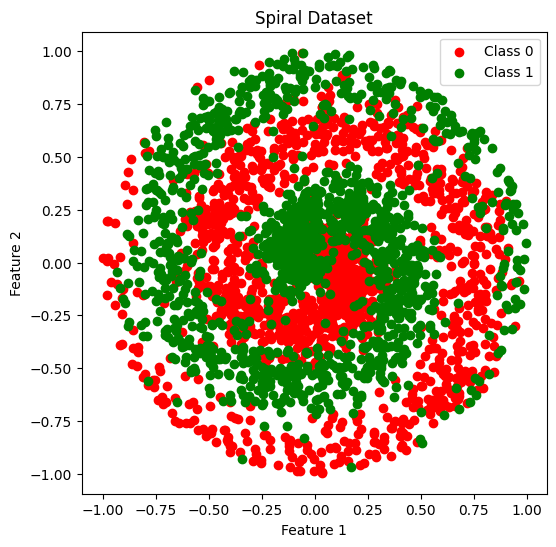

In [ ]:
def plot_input(data):
    plt.figure(figsize=(6,6))
    colors = ['red', 'green', 'blue', 'purple', 'orange']
    for class_number in range(num_classes):
        plt.scatter(X[y == class_number, 0], X[y == class_number, 1], 
                    color=colors[class_number % len(colors)], label=f'Class {class_number}')
    plt.title('Spiral Dataset')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

In [91]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [92]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [93]:
class ODEFunc(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim),
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [94]:
def euler_adjoint(func, y, t, grad_output):
    adj_y = grad_output[-1]
    adj_params = [torch.zeros_like(p) for p in func.parameters()]
    for i in range(len(t) - 1, 0, -1):
        dt = t[i] - t[i - 1]
        y_i = y[i - 1].detach().requires_grad_(True)
        t_i = t[i - 1]
        with torch.enable_grad():
            f_i = func(t_i, y_i)
            loss = torch.sum(f_i * adj_y * dt)
            loss.backward(retain_graph=True)
            adj_y = adj_y + y_i.grad
            y_i.grad = None
            for idx, p in enumerate(func.parameters()):
                if p.requires_grad:
                    if p.grad is not None:
                        adj_params[idx] += p.grad
                        p.grad = None
    adj_y0 = adj_y
    return adj_y0, adj_params


def euler_forward(func, y0, t):
    y = [y0]
    for i in range(len(t) - 1):
        dt = t[i + 1] - t[i]
        y_i = y[-1]
        f_i = func(t[i], y_i)
        y_next = y_i + dt * f_i
        y.append(y_next)
    y = torch.stack(y)  # Shape: [time_steps, batch_size, dim]
    return y

In [95]:
class EulerAdjointMethod(torch.autograd.Function):
    @staticmethod
    def forward(ctx, func, y0, t):
        with torch.no_grad():
            y = euler_forward(func, y0, t)
        ctx.save_for_backward(t, y)
        ctx.func = func
        return y

    @staticmethod
    def backward(ctx, grad_output):
        t, y = ctx.saved_tensors
        func = ctx.func
        adj_y0, adj_params = euler_adjoint(func, y, t, grad_output)
        
        # Assign gradients to the function parameters
        for p, adj_p in zip(func.parameters(), adj_params):
            if p.requires_grad:
                if p.grad is None:
                    p.grad = adj_p.clone()
                else:
                    p.grad += adj_p.clone()
        
        # No gradient for 'func' itself (the ODE function is treated as a fixed module)
        # Gradient for 'y0'
        return (None, adj_y0, None)


In [96]:
def odeint_euler_adjoint(func, y0, t):
    y = EulerAdjointMethod.apply(func, y0, t)
    return y


In [97]:
class NeuralODEClassifier(nn.Module):
    def __init__(self, ode_func, num_classes=3):
        super(NeuralODEClassifier, self).__init__()
        self.ode_func = ode_func
        self.classifier = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, y0, t):
        # Integrate ODE using the adjoint method
        y = odeint_euler_adjoint(self.ode_func, y0, t)
        # Use the final state for classification
        out = self.classifier(y[-1])
        return out


In [101]:
ode_func = ODEFunc()
model = NeuralODEClassifier(ode_func, num_classes=num_classes)

optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

In [102]:
t0, t1 = 0.0, 1.0
num_steps = 40
t = torch.linspace(t0, t1, steps=num_steps)

num_epochs = 100
batch_size = 64
loss_history = []
accuracy_history = []

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

In [103]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        logits = model(batch_X, t)
        loss = loss_func(logits, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(logits, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_X.size(0)
    loss_value = epoch_loss / total
    accuracy = correct / total
    loss_history.append(loss_value)
    accuracy_history.append(accuracy)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss_value:.6f}, Accuracy: {accuracy:.4f}")

Epoch 1/100, Loss: 0.686807, Accuracy: 0.5390
Epoch 10/100, Loss: 0.454891, Accuracy: 0.8043
Epoch 20/100, Loss: 0.378515, Accuracy: 0.8419
Epoch 30/100, Loss: 0.352121, Accuracy: 0.8586
Epoch 40/100, Loss: 0.340745, Accuracy: 0.8548
Epoch 50/100, Loss: 0.346694, Accuracy: 0.8562
Epoch 60/100, Loss: 0.337974, Accuracy: 0.8571
Epoch 70/100, Loss: 0.344957, Accuracy: 0.8552
Epoch 80/100, Loss: 0.331638, Accuracy: 0.8600
Epoch 90/100, Loss: 0.324959, Accuracy: 0.8581
Epoch 100/100, Loss: 0.325092, Accuracy: 0.8629


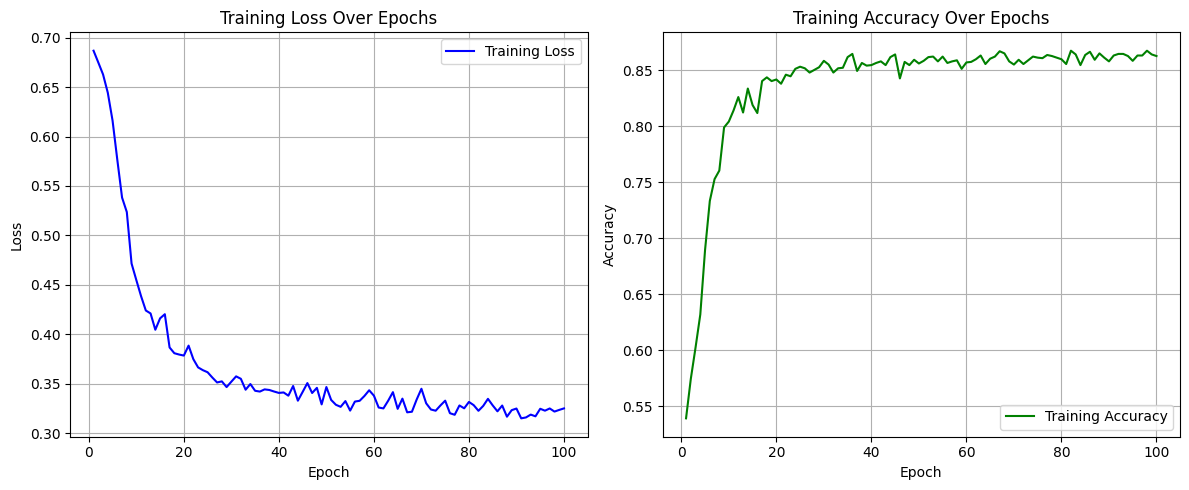

In [104]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_history, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_history, label='Training Accuracy', color='green')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [105]:
model.eval()
with torch.no_grad():
    pred_y = model(X_test, t)
    _, predicted_test = torch.max(pred_y, 1)
    test_accuracy = (predicted_test == y_test).sum().item() / y_test.size(0)
    print(f"Test Accuracy: {test_accuracy:.4f}")

predicted_test_np = predicted_test.numpy()
X_test_np = X_test.numpy()
y_test_np = y_test.numpy()

Test Accuracy: 0.8544


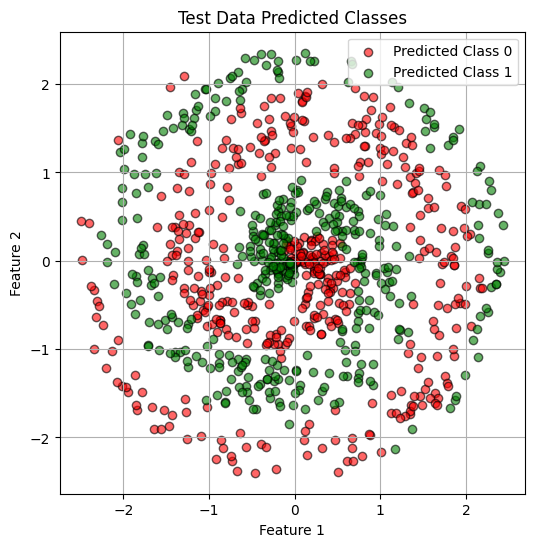

In [106]:
plt.figure(figsize=(6, 6))

for class_number in range(num_classes):
    # Select points predicted to belong to the current class
    idx = predicted_test_np == class_number
    plt.scatter(
        X_test_np[idx, 0], 
        X_test_np[idx, 1], 
        color=colors[class_number % len(colors)], 
        label=f'Predicted Class {class_number}', 
        alpha=0.6, 
        edgecolor='k'
    )

plt.title('Test Data Predicted Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()